# Learning optimization heuristics - Traveling Salesman problem

In [1]:
from sys import maxsize
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math
from scipy.spatial import distance
from collections import namedtuple

## data - locations

### Synthetic "cyclic layers" data

In [2]:
def generate_cyclic_layered_data():
    t = 2 * np.pi * (1 + np.arange(12)) / 12
    cities = np.zeros([60, 2])
    for i in range(12):
        cities[(i * 5):((i + 1) * 5), 0] = np.cos(t[i]) * (1 + np.arange(5))
        cities[(i * 5):((i + 1) * 5), 1] = np.sin(t[i]) * (1 + np.arange(5))
    return cities

In [3]:
coordinates = generate_cyclic_layered_data()

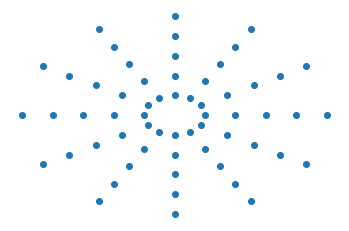

In [4]:
%matplotlib inline
fix, ax = plt.subplots()
plt.scatter(coordinates[:,0],coordinates[:,1])
plt.axis('off')
plt.show()

## Construct graph

### Nodes from coordinates

In [5]:
G = nx.Graph()
nodes = np.arange(coordinates.shape[0])
G.add_nodes_from(nodes)
positions = {node: coord for node, coord in zip(nodes, coordinates)}
labels = {node: str(node) for node in nodes}

In [6]:
G_nodesonly = G.copy()

### Edges based on distance

In [7]:
# Calculating the distances between the nodes as edge's weight.
for i in range(len(coordinates)):
    for j in range(i + 1, len(coordinates)):
        # Multidimensional Euclidean distan
#         dist = math.hypot(coordinates[i][0] - coordinates[j][0], coordinates[i][1] - coordinates[j][1])
        dist = distance.euclidean(coordinates[i,:],coordinates[j,:])
        dist = dist
        G.add_edge(i, j, weight=dist)

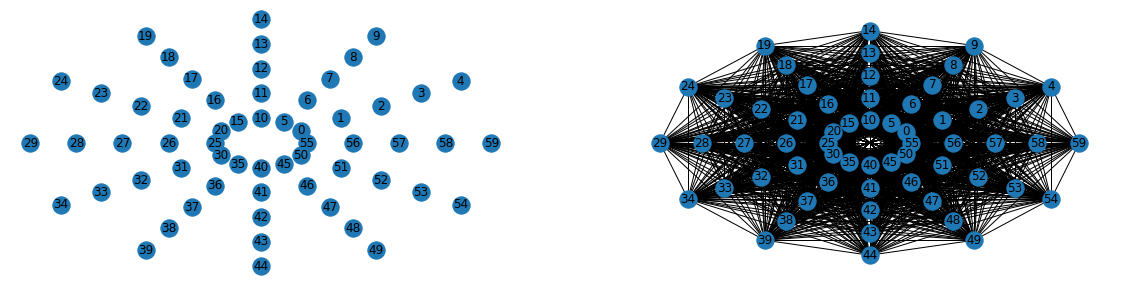

In [8]:
%matplotlib inline
fix, ax = plt.subplots(1,2,figsize=(20,5))
nx.draw_networkx(G_nodesonly, pos=positions, ax=ax[0], labels=labels)
nx.draw_networkx(G, pos=positions, ax=ax[1], labels=labels)
ax[0].axis('off'), ax[1].axis('off')
plt.show()

## Solutions

### Christofides algorithm - (almost) exact solution relying on some approximations

In [9]:
# Check that G is a complete graph
N = len(G) - 1

# This check ignores selfloops which is what we want here.
if any(len(nbrdict) != N for n, nbrdict in G.adj.items()):
    raise nx.NetworkXError("G must be a complete graph.")

In [10]:
cycle = nx_app.christofides(G, weight="weight")

edge_list = list(nx.utils.pairwise(cycle))

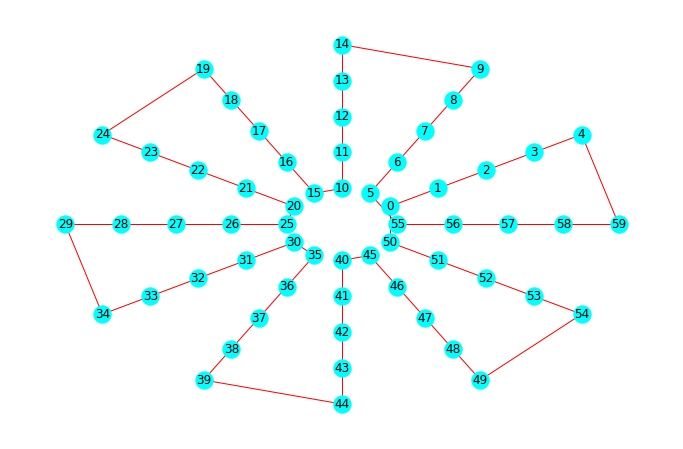

In [11]:
%matplotlib inline
plt.figure(figsize = (12, 8))
nx.draw_networkx(G, pos = positions, labels = labels, node_color = "cyan",
                 edgelist=edge_list, edge_color="red", width = 1)
plt.axis("off")
plt.show()

### Hill climb heuristic

In [12]:
import time
from IPython.display import display, clear_output

In [13]:
coords=coordinates
n=coords.shape[0]
D = np.zeros([n,n])
for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        # Multidimensional Euclidean distan
        #dist = math.hypot(coordinates[i][0] - coordinates[j][0], coordinates[i][1] - coordinates[j][1])
        #dist = distance.euclidean(coordinates[i,:],coordinates[j,:])
        dist = np.sqrt(np.sum((coords[i,:]-coords[j,:])**2))
        D[i,j] = dist
        D[j,i] = dist

def objective_fun(x):
    l=D[x[0],x[n-1]]
    for i in range(n-1):
        l+=D[x[i],x[i+1]]
    return l

In [14]:
def hill_climb(coords,x=None,Niter=100000,plot_iter = 10000):
    """Demo for randomized Hill climb
    
    """    
    # Distance matrix calculation
    n=coords.shape[0]
    D = np.zeros([n,n])
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            # Multidimensional Euclidean distan
            #dist = math.hypot(coordinates[i][0] - coordinates[j][0], coordinates[i][1] - coordinates[j][1])
            #dist = distance.euclidean(coordinates[i,:],coordinates[j,:])
            dist = np.sqrt(np.sum((coords[i,:]-coords[j,:])**2))
            D[i,j] = dist
            D[j,i] = dist
    
    def objective_fun(x):
        l=D[x[0],x[n-1]]
        for i in range(n-1):
            l+=D[x[i],x[i+1]]
        return l
    
    lengths = np.zeros(Niter)
    progress=[]
    if x is None:
        x = np.random.choice(np.arange(n), size=n, replace=False).tolist()
    Lx = objective_fun(x)
    Lmin = Lx
    xmin = x
    #main loop
    for i in range(Niter):
        lengths[i] = Lx
        ## generate candidate
        ind = sorted(np.random.choice(np.arange(n), size=2, replace=False))
        xnew=x.copy()
        xnew[ind[0]] = x[ind[1]]
        xnew[ind[1]] = x[ind[0]]
        
        Lxnew = objective_fun(xnew)
        if Lxnew < Lmin:
            Lmin = Lxnew
            xmin = xnew.copy()
            progress.append(xmin.copy())
        if Lxnew < Lx:
            Lx = Lxnew
            x = xnew
                        
    return dict(x=xmin,L=Lmin,lengths=lengths,xx=xmin,LL=Lx,progress=progress)

In [15]:
sol = hill_climb(coordinates,Niter= 300000, plot_iter = 10000)

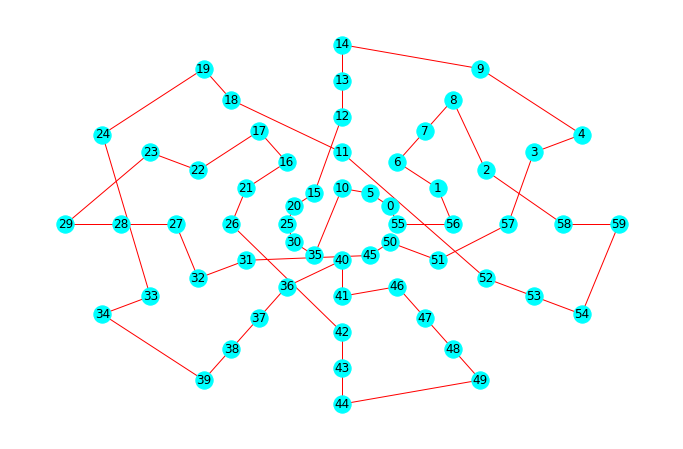

In [16]:
e=[(i,j) for i,j in zip(sol['x'],np.roll(sol['x'],-1))]

plt.figure(figsize = (12, 8))
nx.draw_networkx(G, pos = positions, labels = labels, node_color = "cyan",
                 edgelist=e,edge_color="red", width = 1)
plt.axis("off")
plt.show()

In [17]:
len(sol['progress'])/4

29.5

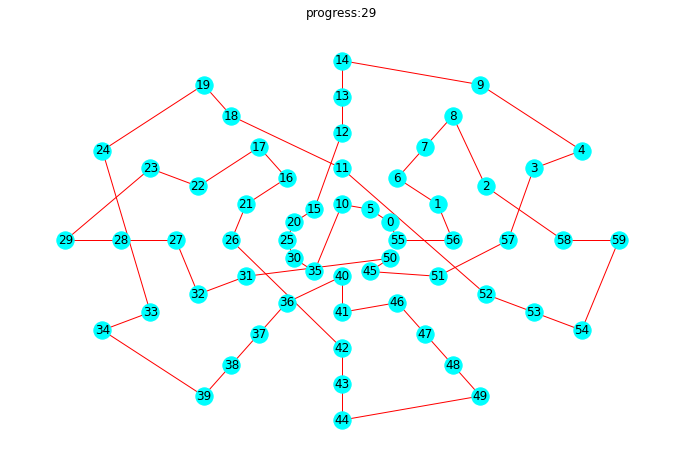

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
for k,prog in enumerate(sol['progress'][::4]):
    e = [(i,j) for i,j in zip(prog,np.roll(prog,-1))]
    ax.cla()
    nx.draw_networkx(G, pos = positions, labels = labels, node_color = "cyan",
                 edgelist=e,ax=ax,
                 edge_color="red", width = 1)
    ax.axis("off")
    ax.set_title(f"progress:{k}")
    display(fig)    
    clear_output(wait = True)
    plt.pause(0.2)
    if k>200:
        break

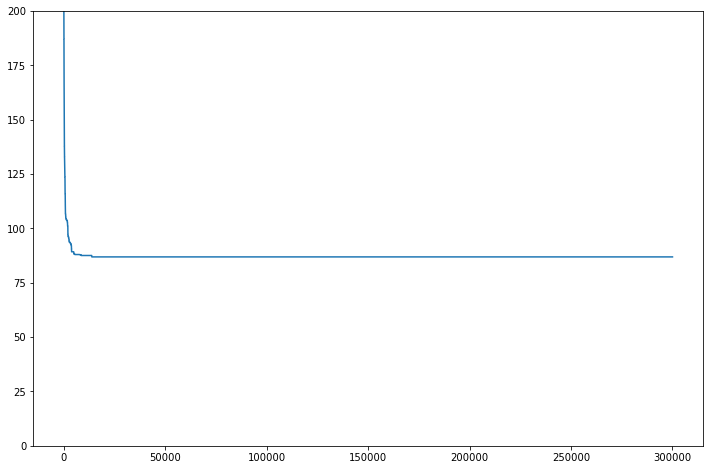

In [19]:
plt.figure(figsize = (12, 8))
plt.plot(sol['lengths'])
plt.ylim(0,200)
plt.show()

In [20]:
sol['L']

86.87307481362753

### Simulated anealling

In [22]:
import tqdm

In [23]:
def sann(coords,x=None,Niter=100000,plot_iter = 10000,tau=10000,method=1):
    """Demo for randomized Hill climb
    
    """    
    # Distance matrix calculation
    n=coords.shape[0]
    D = np.zeros([n,n])
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            # Multidimensional Euclidean distan
            #dist = math.hypot(coordinates[i][0] - coordinates[j][0], coordinates[i][1] - coordinates[j][1])
            #dist = distance.euclidean(coordinates[i,:],coordinates[j,:])
            dist = np.sqrt(np.sum((coords[i,:]-coords[j,:])**2))
            D[i,j] = dist
            D[j,i] = dist
    
    def objective_fun(x):
        l=D[x[0],x[n-1]]
        for i in range(n-1):
            l+=D[x[i],x[i+1]]
        return l
    
    lengths = np.zeros(Niter)
    progress=[]
    if x is None:
        x = np.random.choice(np.arange(n), size=n, replace=False).tolist()
    Lx = objective_fun(x)
    Lmin = Lx
    xmin = x
    #main loop
    for i in tqdm.tqdm(range(Niter),total=Niter):
#         print(i)
        lengths[i] = Lx
        ## generate candidate - 2 methods
        ind = sorted(np.random.choice(np.arange(n), size=2, replace=False))
        if method==1:
            xnew=x.copy()
            xnew[ind[0]] = x[ind[1]]
            xnew[ind[1]] = x[ind[0]]
        elif method==2:
            xrev = list(reversed(x[ind[0]:ind[1]]))
            if (ind[0]==0):
                left=[]
            else:
                left = x[0:(ind[0])]
            if (ind[1]==(n)):
                right=[]
            else:
                right=x[(ind[1]):n]
#             print(x)
#             print(left,type(left))
#             print(xrev,type(xrev))
#             print(right,type(right))
            xnew = left + xrev + right
            assert len(xnew)==len(x)
        else:
            raise()
        
        Lxnew = objective_fun(xnew)
        if Lxnew < Lmin:
            Lmin = Lxnew
            xmin = xnew.copy()
            progress.append(xmin.copy())
        if (np.random.rand()<np.exp(-(Lxnew-Lx)/(tau/1000000))):
            Lx = Lxnew
            x = xnew
                        
    return dict(x=xmin,L=Lmin,lengths=lengths,xx=xmin,LL=Lx,progress=progress)

In [24]:
sol = sann(coordinates,Niter= 300000, plot_iter = 10000,tau=30000,method=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [00:18<00:00, 15900.21it/s]


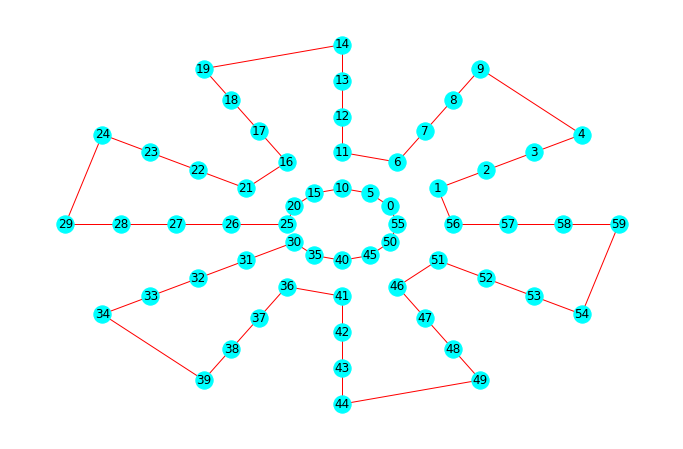

In [25]:
e=[(i,j) for i,j in zip(sol['x'],np.roll(sol['x'],-1))]

plt.figure(figsize = (12, 8))
nx.draw_networkx(G, pos = positions, labels = labels, node_color = "cyan",
                 edgelist=e,edge_color="red", width = 1)
plt.axis("off")
plt.show()

In [26]:
len(sol['progress'])/4

40.0

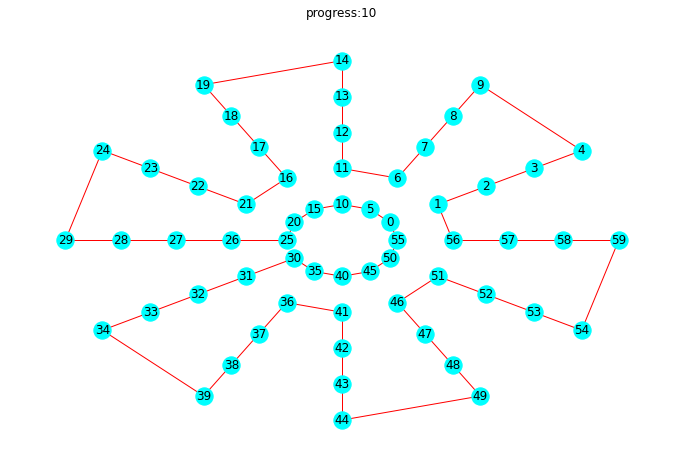

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
for k,prog in enumerate(sol['progress'][::4]+[sol['x']]):
    e = [(i,j) for i,j in zip(prog,np.roll(prog,-1))]
    ax.cla()
    nx.draw_networkx(G, pos = positions, labels = labels, node_color = "cyan",
                 edgelist=e,ax=ax,
                 edge_color="red", width = 1)
    ax.axis("off")
    ax.set_title(f"progress:{k}")
    display(fig)    
    clear_output(wait = True)
    plt.pause(0.2)
    if k>200:
        break

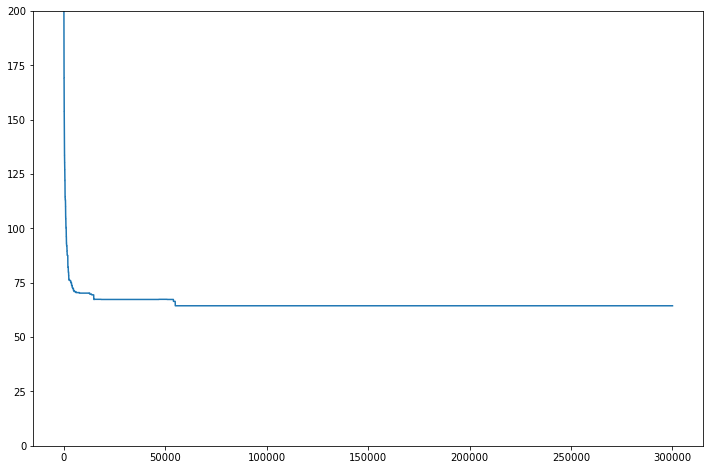

In [30]:
plt.figure(figsize = (12, 8))
plt.plot(sol['lengths'])
plt.ylim(0,200)
plt.show()

In [31]:
sol['L']

64.39954260045711